# Fit MRP parameters to a whole distribution of traditional mass functions with varying physical parameters, and create fitting functions which tie MRP to the physical parameters (via Eureqa)

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from hmf import MassFunction
from scipy.integrate import simps
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from mrpy.fit_curve import get_fit_curve
from mrpy.core import dndm
import os

Our goal in this example is to find functions that relate the MRP parameters, $(\mathcal{H}_s,\alpha,\beta)$ to the physical parameters $(z,\Omega_m,\sigma_8)$. The results of this analysis are *already stored* in the ``physical_dependence`` module of ``mrpy``. This example shows how those models were derived explicitly, and also gives some ideas on how to fit theoretical curves, and the issues that can pop up.

**Figures from this example appear in MRP as figures 11, 12 and 13**

Our first task is to set up the fiducial cosmology and choose a fitting function. We choose the Behroozi+13 SO fitting function, with a fiducial cosmology of Planck+13 (Planck+WP 68% limits):

In [23]:
## FIDUCIAL COSMOLOGY
ns = 0.9603
H0 = 67.3
Ob0 = 0.02205/0.673**2
Om0 = 0.315
s8 = 0.829

## MassFunction Setup
model = dict(#Models
                 hmf_model="Behroozi",cut_fit=False,transfer_model="EH",
                 # Resolution
                 dlog10m=0.01,dlnk=0.005,lnk_min=-15,lnk_max=15,
                 #Cosmology   
                 sigma_8=s8,n=ns,cosmo_params={"Om0":Om0,"Ob0":Ob0,"H0":H0})

h = MassFunction(**model)

## Checking Transfer model and Resolution Parameters

Before we begin our actual analysis, we need to make sure of a few things concerning the models and resolution. Firstly, we want to make sure that using EH isn't a big deal. What we do is plot the resulting mass function ratio of an EH vs CAMB model, for several redshifts (dependence on other parameters will be very small), where the mass is scaled by the log mass mode: 

In [24]:
def get_mass_mode(m,dndm,scalar=True):
    spl = spline(np.log10(m[dndm>0]),(m**2*dndm)[dndm>0],k=4) #k=4 necessary for getting roots next
    d = spl.derivative()
    if scalar:
        return d.roots()[0]
    else:
        return d.roots()

The mass mode will not change significantly over $\Omega_m$ or $\sigma_8$, but will change a lot for redshift. Let's have a look at this dependence, to make sure everything is okay:

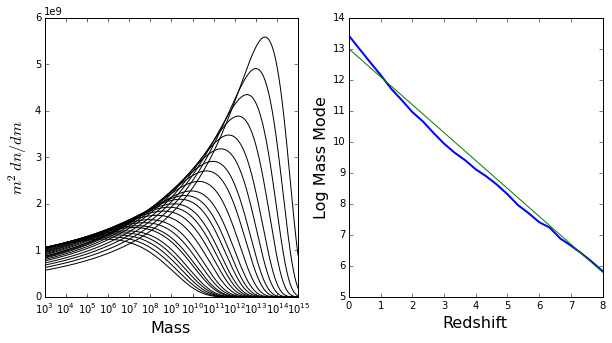

In [25]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

h.update(Mmin=3,Mmax=15)
Z = np.linspace(0,8,25)
mode = np.zeros(len(Z))
for i,z in enumerate(Z):
    h.update(z=z)
    mode[i] = get_mass_mode(h.M,h.dndm)
    ax[0].plot(h.M,h.M**2 * h.dndm,color="k")

ax[0].set_xscale('log')
ax[1].plot(Z,mode,lw=2)
ax[1].plot(Z,13 - 0.9*Z)
ax[1].set_xlabel("Redshift",fontsize=16)
ax[0].set_xlabel("Mass",fontsize=16)
ax[1].set_ylabel("Log Mass Mode",fontsize=16)
ax[0].set_ylabel(r"$m^2 dn/dm$",fontsize=16)

This all looks good (which means that the default resolution parameters are all good for our purposes, but we'll check this more thoroughly soon). Furthermore, we should be able to define a more efficient function which doesn't need to have a huge range of Mmin/Mmax:

In [26]:
def get_mass_mode_h(h,Mmin=-3,Mmax=2):
    estimate = 13 - 0.9*h.z
    finished = False
    i = 0
    while not finished and i<4:
        i += 1
        h.update(Mmin=estimate+1.5*Mmin*i**0.5,Mmax=estimate+1.5*Mmax*i**0.5)
        mode = get_mass_mode(h.M,h.dndm,scalar=False)
        if len(mode)==1 and mode[0]+Mmin > h.Mmin and mode[0]+Mmax < h.Mmax:
            finished = True
        else:
            continue
    return mode[0]

Just for testing, let's use this function to again produce a similar plot to above. This runs quite a bit slower because the integrals have to be done again each time:

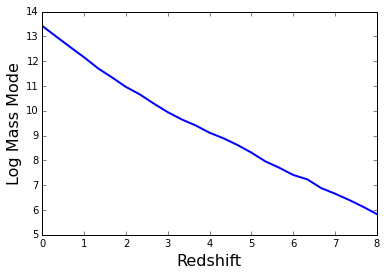

In [30]:
Z = np.linspace(0,8,25)
mode = np.zeros(len(Z))
for i,z in enumerate(Z):
    h.update(z=z)
    mode[i] = get_mass_mode_h(h)

plt.plot(Z,mode,lw=2)
plt.xlabel("Redshift",fontsize=16)
plt.ylabel("Log Mass Mode",fontsize=16)

plt.savefig("../../mrpArticle/figures/log_mass_mode.pdf")

Importantly, we make sure the CAMB run has a high enough ``transfer__kmax`` so that we don't extrapolate in the given $k$ range (otherwise the CAMB value is over-predicted).

In [31]:
def recast_dndm(m,dndm,mode,Mmin=-3,Mmax=2,dm=h.dlog10m):
    mvec = np.arange(mode+Mmin,mode+Mmax,dm)
    sp = spline(np.log10(m[dndm>0]),np.log10(dndm[dndm>0]))
    return 10**sp(mvec)

0 0.989899378927 1.0276044595
1 0.982757565139 1.01197742328
2 0.974405738322 1.01224932332
5 1.01172312844 1.01640256135
8 1.01669515856 1.02558050091


/home/steven/anaconda2/lib/python2.7/site-packages/hmf-2.0.0-py2.7.egg/hmf/hmf.py:499: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1400 but corresponding boolean dimension is 1389


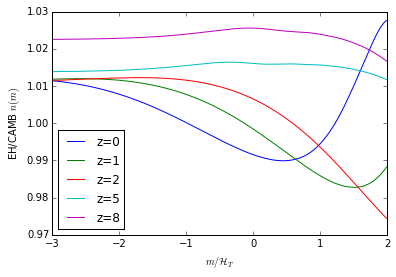

In [33]:
h.update(**model)
eh = []
mass_mode = []
power = []
h.update(transfer_model="EH",transfer_params={},lnk_min=-8,lnk_max=4.5,Mmin=2,Mmax=16)
for i,z in enumerate([0,1,2,5,8]):
    h.update(z=z)
    dndm = h.dndm
    dndm[np.isnan(dndm)] = 0
    power.append(h.power)

    # get log mass mode
    mass_mode.append(get_mass_mode(h.M,dndm))
    eh.append(recast_dndm(h.M,dndm,mass_mode[i]))
    
c_power = []
h.update(transfer_model="CAMB",transfer_params={"transfer__kmax":1000.0,"transfer__k_per_logint":0})
for i,z in enumerate([0,1,2,5,8]):
    h.update(z=z)
    c_power.append(h.power)
    dndm = h.dndm
    dndm[np.isnan(dndm)] = 0
    ratio = eh[i]/recast_dndm(h.M,dndm,mass_mode[i])
    print z, ratio.min(), ratio.max()
    hvec = np.arange(-3,2,h.dlog10m)
    N = min(len(ratio),len(hvec))
    ratio = ratio[:N]
    hvec = hvec[:N]
    plt.plot(hvec,ratio,
         label="z=%s"%str(z))
    
plt.legend(loc=0)
plt.xlabel(r"$m/\mathcal{H}_T$")
plt.ylabel(r"EH/CAMB $n(m)$")

h.update(**model)

Clearly, at most redshifts, EH is good to within 2%. At very high redshifts, the error is just greater than 2%. The reason for this is that in each case, the actual masses probed changes (smaller for higher redshifts). This means that higher redshifts probe higher $k$, and we see below that there is a discrepancy towards high $k$ between EH and CAMB:

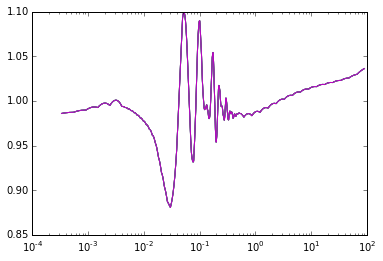

In [35]:
h.update(lnk_min=-8,lnk_max=4.5)
for i in range(5):
    plt.plot(h.k,power[i]/c_power[i])
    
plt.xscale('log')

But this shouldn't matter too much. It's <3% when the fits will be good to ~20%. We also want to quickly check the other resolution parameters. In particular, as we have seen, high-z uses small scales (small mass), so we need to at least include those scales. Here we set the mass limits to be everywhere we could possibly probe in this analysis:

/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide
/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide
/home/steven/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:806: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/home/steven/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:821: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)


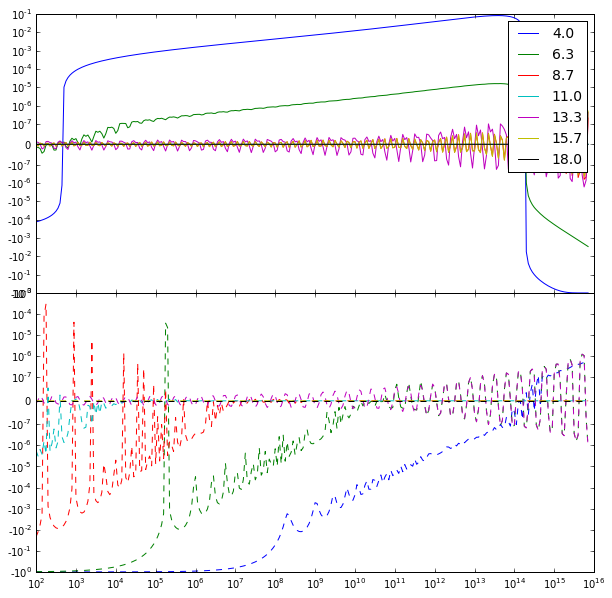

In [38]:
h.update(transfer_model="EH",transfer_params={},lnk_min=-20,lnk_max=20,Mmin=2,Mmax=16,dlog10m=0.05)
fid = h.dndm
fig,ax = plt.subplots(2,1,sharex=True,gridspec_kw={"hspace":0},subplot_kw={"xscale":'log'},figsize=(10,10))
for kbound in np.linspace(4,18,7):
    h.update(lnk_min=-kbound)
    ax[0].plot(h.M,h.dndm/fid-1,label="%1.1f"%kbound)

h.update(lnk_min=-20)

for kbound in np.linspace(4,18,7):
    h.update(lnk_max=kbound)
    ax[1].plot(h.M,h.dndm/fid-1,ls="--")

ax[0].legend(loc=0,fontsize=14)
ax[0].set_yscale('symlog',linthreshy=1e-7)
ax[1].set_yscale('symlog',linthreshy=1e-7)

It would seem that for our purposes, to get better than 0.01% accuracy over all masses, we can use ``lnk_min = -6.5`` and ``lnk_max = 11``. 

The other question is what value of ``dlnk`` should we use? Given our best range, let's check:

/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


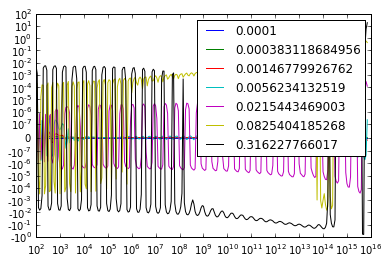

In [39]:
h.update(lnk_min=-6.5,lnk_max=11,dlnk=0.0001)
fid = h.dndm
for dlnk in np.logspace(-4,-0.5,7):
    h.update(dlnk=dlnk)
    plt.plot(h.M,h.dndm/fid-1,label=dlnk)
    
plt.xscale('log')
plt.yscale("symlog",linthreshy=1e-7)
plt.legend(loc=0)

Looks like using 0.02 will do better than 0.001% over most masses. So finally we can set the proper elements:

In [40]:
## FINAL BASE PARAMETERS
model.update(**dict(lnk_min=-6.5,lnk_max=11,dlnk=0.02,dlog10m=0.01))
h.update(**model)

## Mmin and Mmax Determination

We want to choose good mass limits for each parameter set. We do this by setting a constant Mmin and Mmax w.r.t. the mass mode. By setting the mode inside these limits, we ensure a good range to define $\beta$ in each case. Let's have a look at the mass functions inside these limits:

/home/steven/anaconda2/lib/python2.7/site-packages/hmf-2.0.0-py2.7.egg/hmf/hmf.py:499: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1900 but corresponding boolean dimension is 1852
/home/steven/anaconda2/lib/python2.7/site-packages/hmf-2.0.0-py2.7.egg/hmf/hmf.py:499: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1900 but corresponding boolean dimension is 1813
/home/steven/anaconda2/lib/python2.7/site-packages/hmf-2.0.0-py2.7.egg/hmf/hmf.py:499: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1900 but corresponding boolean dimension is 1783
/home/steven/anaconda2/lib/python2.7/site-packages/hmf-2.0.0-py2.7.egg/hmf/hmf.py:499: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1900 but corresponding boolean dimension is 1760
/home/steven/anaconda2/lib/python2.7/site-packages/h

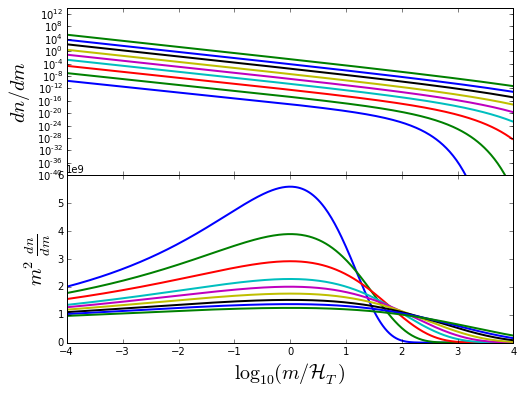

In [42]:
h.update(**model)
h.update(Mmin=-1,Mmax=18)
fig,ax = plt.subplots(2,1,sharex=True,figsize=(8,6),gridspec_kw={"hspace":0})

for z in np.linspace(0,8,9):
    h.update(z=z)
    mode = get_mass_mode(h.M,h.dndm)

    sp = spline(np.log10(h.M[h.dndm>0]),np.log10(h.dndm[h.dndm>0]))
    
    mvec = np.arange(mode-4,mode+4,0.02)
    hvec = np.arange(-4,4,0.02)
    # The following is necessary since sometimes the vectors have 1 more element
    N = min(len(mvec),len(hvec))
    mvec = mvec[:N]
    hvec = hvec[:N]
    
    ax[0].plot(hvec,10**sp(mvec),lw=2)
    ax[1].plot(hvec,10**(2*mvec) * 10**sp(mvec),lw=2)
    
ax[0].set_yscale('log')
ax[0].set_ylim((1e-40,1e14))
ax[1].set_xlabel(r"$\log_{10} (m/\mathcal{H}_T)$",fontsize=20)
ax[0].set_ylabel(r"$dn/dm$",fontsize=20)
ax[1].set_ylabel(r"$m^2 \frac{dn}{dm}$",fontsize=20)

# reset the instance to default
h.update(**model)

In [43]:
Mmin = -3
Mmax = 2

## Data Generation

The main idea is to generate a sample of parameters, $(z,\Omega_m,\sigma_8)$, based on a realistic distribution (i.e. Planck13), then for each parameter, generate the HMF between the relevant limits. Then each HMF is to be fit with the MRP. The resulting parameters will need to be fit in Eureqa, after which we'll port the results back here ;)

So, first up, the general parameters of the samples:

### Parameter Samples

In [44]:
# General configuration for parameter samples
N_1d = 200     # Number of samples to draw for 1D data
N_3d = 2000    # Number of samples to draw for 3D data
s8_mean = s8
s8_sd = 0.012
Om0_mean = Om0
Om0_sd = 0.017

Both $\sigma_8$ and $\Omega_m$ will be sampled from the Planck distribution, but $z$ will come from a log-linear distribution (which more highly weights low redshifts, but not too much). First, define a function which will generate the samples:

In [45]:
def get_parameter_sample(N, zbound,s8_mean=s8_mean,s8_sd=s8_sd,Om0_mean=Om0_mean,Om0_sd=Om0_sd):
    sigma_8 = np.random.normal(s8_mean, s8_sd, size=N)
    Om0 = np.random.normal(Om0_mean, Om0_sd, size=N)
    
    if not hasattr(zbound, "__len__"):
        z = np.repeat(zbound, N)
    else:
        z = np.exp(np.linspace(np.log(1 + zbound[0]), np.log(1 + zbound[1]), N)) - 1
    
    return sigma_8, Om0, z

And a function which generates the EPS mass function from each sample.

In [46]:
def get_hmfs(h, Om0, z, s8,Mmin=-3,Mmax=1):
    # If Om0 is a scalar, then things can be sped up a bit.
    try:
        Om0[3]
        go_for_it = False
    except:
        go_for_it = True
        
    # Make sure they're all vectors
    Om0 = np.atleast_1d(Om0)
    z = np.atleast_1d(z)
    s8 = np.atleast_1d(s8)

    N = max(len(Om0),len(z),len(s8))

    if len(Om0)==1: Om0 = np.repeat(Om0,N)
    if len(s8)==1: s8 = np.repeat(s8,N)
    if len(z)==1: z = np.repeat(z,N)
            
    Nm = len(arange(Mmin,Mmax,h.dlog10m))

    dndm = np.zeros((Nm,N))
    mode = np.zeros(N)
    
    h.update(Mmin=2,Mmax=16)
    for i, (s, zz, m) in enumerate(zip(s8, z, Om0)):
        if i%100==0:
            print float(i) * 100 / float(len(z)), "% done"
        
        h.update(cosmo_params={"Om0":m}, z=zz, sigma_8=s)
        if go_for_it:
            mode[i] = get_mass_mode(h.M,h.dndm)
        else:
            mode[i] = get_mass_mode_h(h)
        
        #get vals at new mass range
        dndm[:,i] = recast_dndm(h.M,h.dndm,mode[i],Mmin=Mmin,Mmax=Mmax,dm=h.dlog10m)[:Nm]
        new_m = arange(mode[i]+Mmin,mode[i]+Mmax,h.dlog10m)
        
        # for some reason, sometimes new_m is 1 bigger than needed
        if len(new_m)>Nm:
            new_m = new_m[:Nm]
            
        
    return dndm,mode

Now, try to read the samples in from a data file, otherwise produce them again.

In [51]:
# ensure hmf is the proper model
h.update(transfer_params={},**model)

if os.path.exists("phys_dep/raw_data.npz"):
    all_data = np.load("phys_dep/raw_data.npz")

    # 3d
    s8_3d = all_data["s8_3d"]
    Om0_3d = all_data["Om0_3d"]
    z_3d = all_data["z_3d"]
    dndm_3d = all_data["dndm_3d"]
    Ht_3d = all_data["Ht_3d"]
    
    # 1d
    s8_1d = all_data["s8_1d"]
    Om0_1d = all_data["Om0_1d"]
    z_1d = all_data["z_1d"]
    dndm_z_1d = all_data['dndm_z_1d']
    dndm_s8_1d = all_data['dndm_s8_1d']
    dndm_Om0_1d = all_data['dndm_Om0_1d']
    Ht_z_1d = all_data['Ht_z_1d']
    Ht_s8_1d = all_data['Ht_s8_1d']
    Ht_Om0_1d = all_data['Ht_Om0_1d']
    del all_data
else:
    # Create Samples
    s8_1d, Om0_1d, z_1d = get_parameter_sample(N_1d,(0,8))
    s8_3d, Om0_3d, z_3d = get_parameter_sample(N_3d,(0,8))
    
    # Calculate HMF's
    dndm_s8_1d, Ht_s8_1d = get_hmfs(h,Om0,0,s8_1d,Mmin=Mmin,Mmax=Mmax)
    dndm_Om0_1d, Ht_Om0_1d = get_hmfs(h,Om0_1d,0,s8,Mmin=Mmin,Mmax=Mmax)
    dndm_z_1d, Ht_z_1d = get_hmfs(h,Om0,z_1d,s8,Mmin=Mmin,Mmax=Mmax)
    print "done 1d z"

    dndm_3d, Ht_3d = get_hmfs(h,Om0_3d,z_3d,s8_3d,Mmin=Mmin,Mmax=Mmax)
    print "done 3d 8"

For good measure, check the distributions:

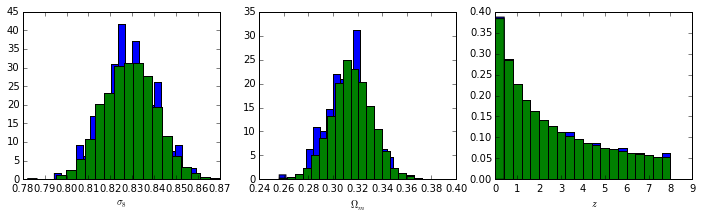

In [52]:
fig,ax = plt.subplots(1,3,figsize=(12,3))

ax[0].hist(s8_1d,normed=True,bins=20)
ax[1].hist(Om0_1d,normed=True,bins=20)

ax[0].hist(s8_3d,normed=True,bins=20)
ax[1].hist(Om0_3d,normed=True,bins=20)

ax[2].hist(z_1d,normed=True,bins=20)
ax[2].hist(z_3d,normed=True,bins=20)

ax[0].set_xlabel(r"$\sigma_8$")
ax[1].set_xlabel(r"$\Omega_m$")
ax[2].set_xlabel(r"$z$")

To me, it looks like the best choice will be something like (-3,2). This will give an upper limit of about 15.5 at z=0, which is pretty close to the largest things we expect to find.At high redshift, this will reach down to $M_{\rm min} \approx 3$, which is incredibly small, but hey, who trusts these scales anyway? 

Now save the data for use next time...

In [53]:
np.savez("phys_dep/raw_data.npz",s8_3d=s8_3d,Om0_3d=Om0_3d,z_3d=z_3d,dndm_3d=dndm_3d,Ht_3d=Ht_3d,
         z_1d=z_1d,dndm_z_1d=dndm_z_1d,Ht_z_1d=Ht_z_1d,
         s8_1d = s8_1d,dndm_s8_1d=dndm_s8_1d,Ht_s8_1d=Ht_s8_1d,
         Om0_1d = Om0_1d,dndm_Om0_1d=dndm_Om0_1d,Ht_Om0_1d=Ht_Om0_1d)

Now it would be good to have a look at all the fits to make sure they look reasonable.

In [54]:
def plot_sample(sample,m,ax=None,ratio=False,color="k",alpha=0.3,label=None,**kwargs):
    if ax is None:
        ax = plt.subplot(111)
        
    for i in range(sample.shape[1]):
        if i>0:
            label=None
        if ratio:
            ax.plot(m,sample[:,i]/sample[:,0],color=color,alpha=alpha,label=label**kwargs)
        else:
            ax.plot(m,sample[:,i],color=color,alpha=alpha,label=label,**kwargs)

First look at all the 1d distros

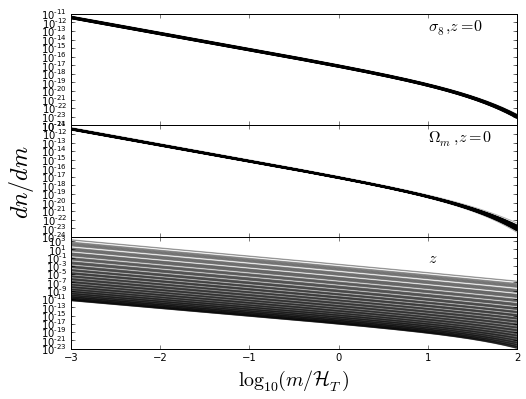

In [56]:
mvec = np.arange(Mmin,Mmax,h.dlog10m)

fig,ax=plt.subplots(3,1,sharex=True,gridspec_kw={"hspace":0.0},subplot_kw={"yscale":'log'},figsize=(8,6))
for i,sample in enumerate([dndm_s8_1d,dndm_Om0_1d,dndm_z_1d]):
    plot_sample(sample,mvec,ax[i],ratio=False)
    

ax[2].set_xlabel(r"$\log_{10}(m/\mathcal{H}_T)$",fontsize=20)
ax[1].set_ylabel(r"$dn/dm$",fontsize=24)
ax[0].text(1,1e-13,r"$\sigma_8, z=0$",fontsize=16)
ax[1].text(1,1e-13,r"$\Omega_m, z=0$",fontsize=16)
ax[2].text(1,1e-2,r"$z$",fontsize=16)

These look nice and contiguous as we would expect. Now the 3d distros:

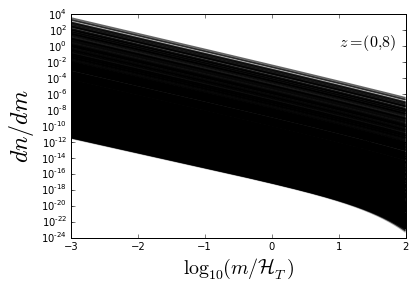

In [60]:
mvec = np.arange(Mmin,Mmax,h.dlog10m)

plot_sample(dndm_3d,mvec,ratio=False)

plt.xlabel(r"$\log_{10}(m/\mathcal{H}_T)$",fontsize=20)
plt.ylabel(r"$dn/dm$",fontsize=24)
plt.text(1,1e-13,r"$z=0$",fontsize=16)
plt.text(1,1e0,r"$z=(0,8)$",fontsize=16)
plt.yscale('log')

### Fit MRP

First we define a generic function that will fit the dndm vectors.

In [61]:
def fit_all_mrp(sample,mode,Om0=None,Mmin=-3,Mmax=1,s=0):
    par = np.zeros((sample.shape[1],4))
    fit = np.zeros_like(sample)
    
    if Om0 is None:
        Om0 = np.zeros(sample.shape[1])
        
    guesstimate = [14.5,-1.9,0.8,-40]
    for i,(dndm,m) in enumerate(zip(sample.T,mode)):
        M = 10**np.arange(m+Mmin,m+Mmax,h.dlog10m)[:len(dndm)]
        res,curve = fit_curve(M,dndm,hs0=guesstimate[0],alpha0=guesstimate[1],
                                 beta0=guesstimate[2],lnA0=guesstimate[3])

        par[i] = res.x
        fit[:,i] = curve.dndm()
        guesstimate = par[i]
    return par,fit

And now a couple of functions which plot the results:

In [65]:
def plot_mrp_fit(fit_dict,ax=None,Mmin=Mmin,Mmax=Mmax,dm=h.dlog10m):
    if ax is None:
        ax = plt.subplot(111)
        
    mvec = np.arange(Mmin,Mmax,dm)[:dndm_3d.shape[0]]
    for i in range(dndm_3d.shape[1]):
        ax.plot(mvec,fit_dict["fit_3d"][:,i]/dndm_3d[:,i],color="k",alpha=0.2)
        
def plot_mrp_param_dep(fit_dict):
    fig,ax=plt.subplots(5,3,sharex="col",gridspec_kw={"hspace":0},figsize=(12,8))

    for i in range(5):
        if i<4:
            ax[i,0].scatter(s8_1d,fit_dict['par_s8_1d'][:,i])
        else:
            ax[i,0].scatter(s8_1d,Ht_s8_1d)
        ax[i,0].set_ylabel([r"$\mathcal{H}_s$",r"$\alpha$",r"$\beta$",r"$\log A$",r"$\mathcal{H}_T$"][i],fontsize=16)

    for i in range(5):
        if i<4:
            ax[i,1].scatter(Om0_1d,fit_dict['par_Om0_1d'][:,i])
        else:
            ax[i,1].scatter(Om0_1d,Ht_Om0_1d)

    for i in range(5):
        if i<4:
            ax[i,2].plot(z_1d,fit_dict['par_z_1d'][:,i])
        else:
            ax[i,2].plot(z_1d,Ht_z_1d)

    for i in range(3):
        ax[3,i].set_xlabel([r"$\sigma_8$",r"$\Omega_m$",r"$z$"][i],fontsize=16)

Here we generate the data (again, only if not found in a corresponding file already):

In [63]:
if os.path.exists('phys_dep/fits.npz'):
    fits = dict(np.load("phys_dep/fits.npz"))
else:
    fits = {}
    fits["par_s8_1d"], fits["fit_s8_1d"]  = fit_all_mrp(dndm_s8_1d , Ht_s8_1d, Mmin=Mmin,Mmax=Mmax)
    fits["par_Om0_1d"],fits["fit_Om0_1d"] = fit_all_mrp(dndm_Om0_1d, Ht_Om0_1d,Mmin=Mmin,Mmax=Mmax)
    fits["par_z_1d"],  fits["fit_z_1d"]   = fit_all_mrp(dndm_z_1d  , Ht_z_1d,  Mmin=Mmin,Mmax=Mmax)
    fits["par_3d"],    fits["fit_3d"]     = fit_all_mrp(dndm_3d    , Ht_3d,    Mmin=Mmin,Mmax=Mmax)

np.savez("phys_dep/fits.npz",**fits)    
np.savetxt("phys_dep/s8_fits.dat",np.vstack((s8_1d,fits['par_s8_1d'].T)).T)
np.savetxt("phys_dep/Om0_fits.dat",np.vstack((Om0_1d,fits['par_Om0_1d'].T)).T)
np.savetxt("phys_dep/z_fits.dat",np.vstack((z_1d,fits['par_z_1d'].T)).T)
np.savetxt("phys_dep/3d_fits.dat",np.vstack((s8_3d,Om0_3d,z_3d,fits['par_3d'].T)).T)

Now plot the resulting functions.

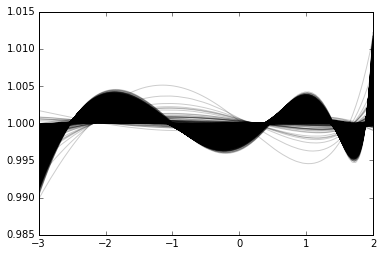

/home/steven/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


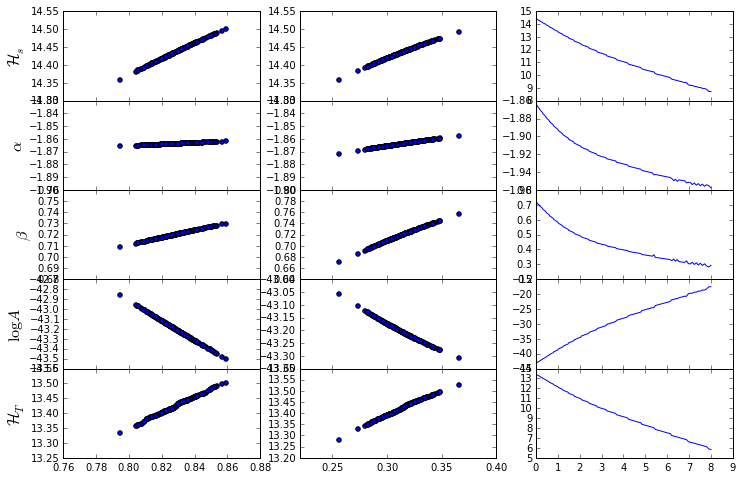

In [66]:
plot_mrp_fit(fits)
plot_mrp_param_dep(fits)

## Return from Eureqa

The data we generated was input to the program "Eureqa" to determine relationships between the physical and MRP parameters. The results were then implemented in ``physical_dependence``.

### Get new fits for all the data

First, we define a helper function for putting labels above entire rows/columns of axes:

In [73]:
def suplabel(axis,label,label_prop=None,
             labelpad=5,
             ha='center',va='center'):
    ''' Add super ylabel or xlabel to the figure
    Similar to matplotlib.suptitle
    axis       - string: "x" or "y"
    label      - string
    label_prop - keyword dictionary for Text
    labelpad   - padding from the axis (default: 5)
    ha         - horizontal alignment (default: "center")
    va         - vertical alignment (default: "center")
    '''
    fig = plt.gcf()
    xmin = []
    ymin = []
    for ax in fig.axes:
        xmin.append(ax.get_position().xmin)
        ymin.append(ax.get_position().ymin)
    xmin,ymin = min(xmin),min(ymin)
    dpi = fig.dpi
    if axis.lower() == "y":
        rotation=90.
        x = xmin-float(labelpad)/dpi
        y = 0.5
    elif axis.lower() == 'x':
        rotation = 0.
        x = 0.5
        y = ymin - float(labelpad)/dpi
    else:
        raise Exception("Unexpected axis: x or y")
    if label_prop is None: 
        label_prop = dict()
    plt.text(x,y,label,rotation=rotation,
               transform=fig.transFigure,
               ha=ha,va=va,
               **label_prop)

We basically run through all our samples, generating fits for them based on the parameterisations we created, then we plot each as a ratio to the true HMF. For some more clarity, we do this in several redshift bins. 

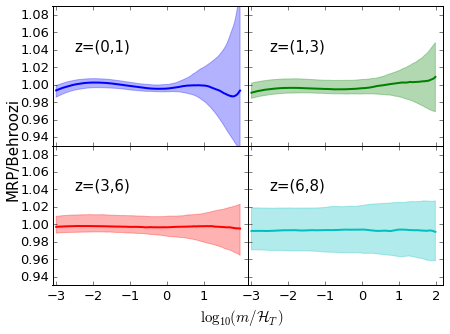

In [75]:
# Import the necessary function
from mrpy.physical_dependence import mrp_b13, _alpha_b13, _beta_b13, _logHs_b13, _lnA_b13

# Define each mass function based on our results
post_fit = np.zeros_like(dndm_3d)
for i,(z,m,s,mode) in enumerate(zip(z_3d,Om0_3d,s8_3d,Ht_3d)):
    mvec = 10**np.arange(mode+Mmin,mode+Mmax,h.dlog10m)[:len(dndm_3d)]
    post_fit[:,i] = mrp_b13(mvec,z,m,s)

# Create a figure plotting the average ratio of the functions
# to the true HMF, with shading giving the uncertainty region.
ratio = post_fit/dndm_3d
hvec = np.arange(Mmin,Mmax,0.01)[:len(mvec)]
cols = ["b","g","r","c"]
fig,ax = plt.subplots(2,2,sharey=True,sharex="col",figsize=(7,5),gridspec_kw={"hspace":0,"wspace":0},
                      subplot_kw={"ylim":(0.93,1.09),"xlim":(-3.1,2.2)})

for j,zrange in enumerate([(0,1),(1,3),(3,6),(6,8)]):
    mask = np.logical_and(z_3d>=zrange[0], z_3d < zrange[-1])
    mean = np.median(ratio[:,mask],axis=1)
    qlow, qhi = np.percentile(ratio[:,mask],(16,84),axis=1)
    
    ax[divmod(j,2)].plot(hvec,mean,lw=2,color=cols[j],label="z=(%s,%s)"%zrange)
    ax[divmod(j,2)].fill_between(hvec,qlow,qhi,color=cols[j],alpha=0.3)
    ax[divmod(j,2)].text(-2.5,1.04,"z=(%s,%s)"%zrange,fontsize=15)
    ax[divmod(j,2)].tick_params(axis='both', which='major', labelsize=13)
    if j==2:
        ax[divmod(j,2)].xaxis.set_ticks([-3,-2,-1,0,1])
suplabel('x',r"$\log_{10}(m/\mathcal{H}_T)$",label_prop={"fontsize":15},labelpad=7)
suplabel("y","MRP/Behroozi",label_prop={"fontsize":15},labelpad=6)

# Save for the paper!
plt.savefig("../../../mrpArticle/figures/param_3d.pdf")

Also, we can re-look at the parameter dependence with included parameterisations:

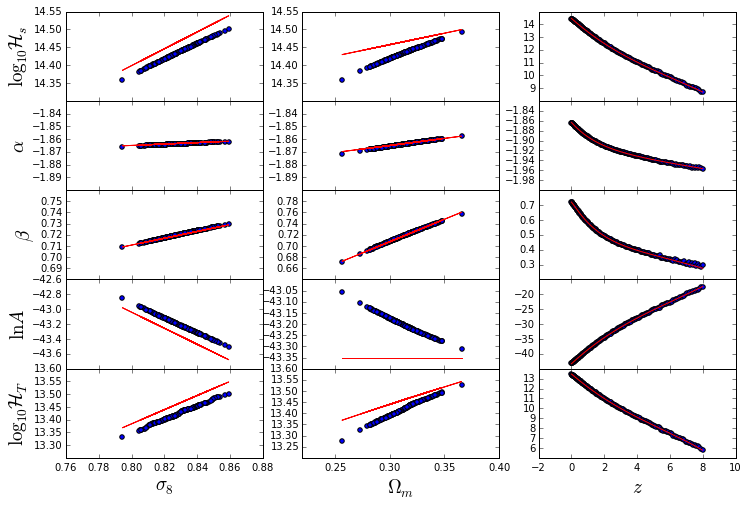

In [78]:
fig,ax=plt.subplots(5,3,sharex="col",gridspec_kw={"hspace":0},figsize=(12,8))

## Dependence on s8
Hs = _logHs_b13(0,Om0,s8_1d)
alpha = _alpha_b13(0,Om0,s8_1d)
beta = _beta_b13(0,Om0,s8_1d)
lnA = _lnA_b13(0,Om0,s8_1d)
param = [Hs,alpha,beta,lnA]
for i in range(5):
    if i<4:
        ax[i,0].scatter(s8_1d,fits['par_s8_1d'][:,i])
        ax[i,0].plot(s8_1d,param[i],color="r")
    else:
        ax[i,0].scatter(s8_1d,Ht_s8_1d)
        ax[i,0].plot(s8_1d,Hs+np.log10((alpha+2)/beta)/beta,color="r")
        
    ax[i,0].set_ylabel([r"$\log_{10}\mathcal{H}_s$",r"$\alpha$",r"$\beta$",r"$\ln A$",r"$\log_{10}\mathcal{H}_T$"][i],fontsize=19)

## Dependence on Om0
Hs = _logHs_b13(0,Om0_1d,s8)
alpha = _alpha_b13(0,Om0_1d,s8)
beta = _beta_b13(0,Om0_1d,s8)
lnA = _lnA_b13(0,Om0_1d,s8)
param = [Hs,alpha,beta,lnA]
for i in range(5):
    if i<4:
        ax[i,1].scatter(Om0_1d,fits['par_Om0_1d'][:,i])
        ax[i,1].plot(Om0_1d,param[i],color="r")
    else:
        ax[i,1].scatter(Om0_1d,Ht_Om0_1d)
        ax[i,1].plot(Om0_1d,Hs+np.log10((alpha+2)/beta)/beta,color="r")

## Dependence on z
Hs = _logHs_b13(z_1d,Om0,s8)
alpha = _alpha_b13(z_1d,Om0,s8)
beta = _beta_b13(z_1d,Om0,s8)
lnA = _lnA_b13(z_1d,Om0,s8)
param = [Hs,alpha,beta,lnA]
for i in range(5):
    if i<4:
        ax[i,2].scatter(z_1d,fits['par_z_1d'][:,i])
        ax[i,2].plot(z_1d,param[i],color="r")
    else:
        ax[i,2].scatter(z_1d,Ht_z_1d)
        ax[i,2].plot(z_1d,Hs+np.log10((alpha+2)/beta)/beta,color="r")

        
for i in range(3):
    ax[4,i].set_xlabel([r"$\sigma_8$",r"$\Omega_m$",r"$z$"][i],fontsize=19)
    
for i in range(5):
    for j in range(3):
        yticks = ax[i,j].yaxis.get_major_ticks()
        yticks[0].label1.set_visible(False)
        yticks[-1].label1.set_visible(False)
        
# Save for the paper!
plt.savefig("../../../mrpArticle/figures/param_dep.pdf")